In [7]:
import os

using_colab = False
if using_colab:
  os.system('rm -rf ./*')
  os.system('git clone https://github.com/gasparyanartur/radio-optimizer.git')
  os.system('mv radio-optimizer/* ./')
  os.system('rm -rf radio-optimizer')

(no blockage)	PWM: PEB = 0.026133 | CEB = 0.013426
(with blockage)	PWM: PEB = 0.069256 | CEB = 0.064823


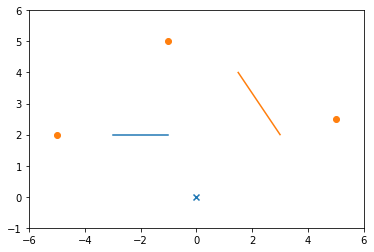

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from src.utils import db2pow

from src.channel_mmWave_parameters import ChannelmmWaveParameters

c = ChannelmmWaveParameters(
    PB = np.array([0, -0.01, 0]).reshape(-1, 1),
    OB = np.array([45, 0, 0]).reshape(-1, 1),
    NB_dim = np.array([1, 1]).reshape(-1, 1),
    PR = np.array([[-5.01, 2, 0.5], [-1, 5.01, 0.5], [5.01, 2.5, 0.5]]).T,
    OR = np.array([[0, 0, 0], [-90, 0, 0], [180, 0, 0]]).T,
    NR_dim = np.array([[10, 10], [10, 10], [10, 10]]).T,
    PU = np.array([-2, 3, -1.5]).reshape(-1, 1),
    OU = np.array([0, 0, 0]).reshape(-1, 1),
    NU_dim = np.array([1, 1]).reshape(-1, 1),
    P = db2pow(15),
    K = 64,
    G = 10,

    seed=1
)

c.get_beam_matrix()
c.get_tx_symbol()
c.get_path_parameters_PWM()
c.get_FIM_PWM()

fim = c.FIM
c.get_crlb_from_fim_PWM(fim)
print(f"(no blockage)\tPWM: PEB = {c.PEB:.6f} | CEB = {c.CEB:.6f}")

c.plot_scene()

point = np.array([2, 4])
blockage = c.get_blockage(point)
c.get_crlb_blockage(blockage)

print(f"(with blockage)\tPWM: PEB = {c.PEB:.6f} | CEB = {c.CEB:.6f}")